# Julia is fast

Very often, benchmarks are used to compare languages.  These benchmarks can lead to long discussions, first as to exactly what is being benchmarked and secondly what explains the differences.  These simple questions can sometimes get more complicated than you at first might imagine.

The purpose of this notebook is for you to see a simple benchmark for yourself.  One can read the notebook and see what happened on the author's Macbook Pro with a 4-core Intel Core I7, or run the notebook yourself.

(This material began life as a wonderful lecture by Steven Johnson at MIT: https://github.com/stevengj/18S096/blob/master/lectures/lecture1/Boxes-and-registers.ipynb.)

# Outline of this notebook

- Define the sum function
- Implementations & benchmarking of sum in...
    - C (hand-written)
    - C (hand-written with -ffast-math)
    - python (built-in)
    - python (numpy)
    - python (hand-written)
    - Julia (built-in)
    - Julia (hand-written)
    - Julia (hand-written with SIMD)
- Summary of benchmarks

# `sum`: An easy enough function to understand

Consider the  **sum** function `sum(a)`, which computes
$$
\mathrm{sum}(a) = \sum_{i=1}^n a_i,
$$
where $n$ is the length of `a`.

In [1]:
a = rand(10^7) # 1D vector of random numbers, uniform on [0,1)

10000000-element Array{Float64,1}:
 0.25289582997215354
 0.9687647030769351
 0.5999303202438562
 0.07944796580999003
 0.7312857733820781
 0.06803533263379413
 0.24133883808285606
 0.3844615264850402
 0.8814481579611559
 0.03421873536427955
 0.9445166871122128
 0.031246605874881928
 0.043851591512321875
 ⋮
 0.3881536026580279
 0.1471833434069958
 0.3226155674725537
 0.6996053425132356
 0.9104229135996598
 0.2933750617411408
 0.12466681077788011
 0.8813521215944264
 0.8453053349420023
 0.5777072167697059
 0.9038196821686146
 0.9285805648001442

In [2]:
sum(a)

5.000671864360599e6

The expected result is 0.5 * 10^7, since the mean of each entry is 0.5

# Benchmarking a few ways in a few languages

In [3]:
@time sum(a)

  0.005059 seconds (1 allocation: 16 bytes)


5.000671864360599e6

In [4]:
@time sum(a)

  0.005680 seconds (1 allocation: 16 bytes)


5.000671864360599e6

In [5]:
@time sum(a)

  0.005347 seconds (1 allocation: 16 bytes)


5.000671864360599e6

The `@time` macro can yield noisy results, so it's not our best choice for benchmarking!

Luckily, Julia has a `BenchmarkTools.jl` package to make benchmarking easy and accurate:

In [6]:
using Pkg
Pkg.add("BenchmarkTools")

   Updating registry at `~/.julia/registries/General`


   Updating git-repo `https://github.com/JuliaRegistries/General.git`


Fetching: [========================================>]  100.0 %

  Resolving package versions...
  Installed BenchmarkTools ─ v0.5.0
   Updating `~/.julia/environments/v1.4/Project.toml`
  [6e4b80f9] + BenchmarkTools v0.5.0
   Updating `~/.julia/environments/v1.4/Manifest.toml`
  [6e4b80f9] + BenchmarkTools v0.5.0


In [7]:
using BenchmarkTools

┌ Info: Precompiling BenchmarkTools [6e4b80f9-dd63-53aa-95a3-0cdb28fa8baf]
└ @ Base loading.jl:1260


#  1. The C language

C is often considered the gold standard: difficult on the human, nice for the machine. Getting within a factor of 2 of C is often satisfying. Nonetheless, even within C, there are many kinds of optimizations possible that a naive C writer may or may not get the advantage of.

The current author does not speak C, so he does not read the cell below, but is happy to know that you can put C code in a Julia session, compile it, and run it. Note that the `"""` wrap a multi-line string.

In [8]:
using Libdl
C_code = """
#include <stddef.h>
double c_sum(size_t n, double *X) {
    double s = 0.0;
    for (size_t i = 0; i < n; ++i) {
        s += X[i];
    }
    return s;
}
"""

const Clib = tempname()   # make a temporary file


# compile to a shared library by piping C_code to gcc
# (works only if you have gcc installed):

open(`gcc -fPIC -O3 -msse3 -xc -shared -o $(Clib * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code)
end

# define a Julia function that calls the C function:
c_sum(X::Array{Float64}) = ccall(("c_sum", Clib), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum (generic function with 1 method)

In [9]:
c_sum(a)

5.000671864360082e6

In [10]:
c_sum(a) ≈ sum(a) # type \approx and then <TAB> to get the ≈ symbolb

true

In [11]:
c_sum(a) - sum(a)

-5.168840289115906e-7

In [12]:
≈  # alias for the `isapprox` function

isapprox (generic function with 8 methods)

In [13]:
?isapprox

search: isapprox



```
isapprox(x, y; rtol::Real=atol>0 ? 0 : √eps, atol::Real=0, nans::Bool=false, norm::Function)
```

Inexact equality comparison: `true` if `norm(x-y) <= max(atol, rtol*max(norm(x), norm(y)))`. The default `atol` is zero and the default `rtol` depends on the types of `x` and `y`. The keyword argument `nans` determines whether or not NaN values are considered equal (defaults to false).

For real or complex floating-point values, if an `atol > 0` is not specified, `rtol` defaults to the square root of [`eps`](@ref) of the type of `x` or `y`, whichever is bigger (least precise). This corresponds to requiring equality of about half of the significand digits. Otherwise, e.g. for integer arguments or if an `atol > 0` is supplied, `rtol` defaults to zero.

`x` and `y` may also be arrays of numbers, in which case `norm` defaults to the usual `norm` function in LinearAlgebra, but may be changed by passing a `norm::Function` keyword argument. (For numbers, `norm` is the same thing as `abs`.) When `x` and `y` are arrays, if `norm(x-y)` is not finite (i.e. `±Inf` or `NaN`), the comparison falls back to checking whether all elements of `x` and `y` are approximately equal component-wise.

The binary operator `≈` is equivalent to `isapprox` with the default arguments, and `x ≉ y` is equivalent to `!isapprox(x,y)`.

Note that `x ≈ 0` (i.e., comparing to zero with the default tolerances) is equivalent to `x == 0` since the default `atol` is `0`.  In such cases, you should either supply an appropriate `atol` (or use `norm(x) ≤ atol`) or rearrange your code (e.g. use `x ≈ y` rather than `x - y ≈ 0`).   It is not possible to pick a nonzero `atol` automatically because it depends on the overall scaling (the "units") of your problem: for example, in `x - y ≈ 0`, `atol=1e-9` is an absurdly small tolerance if `x` is the [radius of the Earth](https://en.wikipedia.org/wiki/Earth_radius) in meters, but an absurdly large tolerance if `x` is the [radius of a Hydrogen atom](https://en.wikipedia.org/wiki/Bohr_radius) in meters.

# Examples

```jldoctest
julia> 0.1 ≈ (0.1 - 1e-10)
true

julia> isapprox(10, 11; atol = 2)
true

julia> isapprox([10.0^9, 1.0], [10.0^9, 2.0])
true

julia> 1e-10 ≈ 0
false

julia> isapprox(1e-10, 0, atol=1e-8)
true
```


We can now benchmark the C code directly from Julia:

In [15]:
c_bench = @benchmark c_sum($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     12.874 ms (0.00% GC)
  median time:      13.442 ms (0.00% GC)
  mean time:        13.582 ms (0.00% GC)
  maximum time:     17.468 ms (0.00% GC)
  --------------
  samples:          368
  evals/sample:     1

In [16]:
println("C: Fastest time was $(minimum(c_bench.times) / 1e6) msec")

C: Fastest time was 12.873992 msec


In [17]:
d = Dict()  # a "dictionary", i.e. an associative array
d["C"] = minimum(c_bench.times) / 1e6  # in milliseconds
d

Dict{Any,Any} with 1 entry:
  "C" => 12.874

In [18]:
using Plots
gr()

Plots.GRBackend()

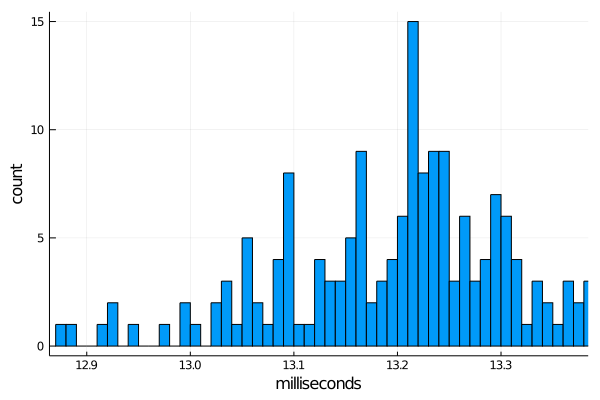

In [19]:
using Statistics # bring in statistical support for standard deviations
t = c_bench.times / 1e6 # times in milliseconds
m, σ = minimum(t), std(t)

histogram(t, bins=500,
    xlim=(m - 0.01, m + σ),
    xlabel="milliseconds", ylabel="count", label="")
# # 2. C with -ffast-math

In [20]:
# If we allow C to re-arrange the floating point operations, then it'll vectorize with SIMD (single instruction, multiple data) instructions.
const Clib_fastmath = tempname()   # make a temporary file

# The same as above but with a -ffast-math flag added
open(`gcc -fPIC -O3 -msse3 -xc -shared -ffast-math -o $(Clib_fastmath * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code)
end

# define a Julia function that calls the C function:
c_sum_fastmath(X::Array{Float64}) = ccall(("c_sum", Clib_fastmath), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum_fastmath (generic function with 1 method)

In [21]:
c_fastmath_bench = @benchmark $c_sum_fastmath($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     7.721 ms (0.00% GC)
  median time:      8.400 ms (0.00% GC)
  mean time:        8.618 ms (0.00% GC)
  maximum time:     12.262 ms (0.00% GC)
  --------------
  samples:          580
  evals/sample:     1

In [22]:
d["C -ffast-math"] = minimum(c_fastmath_bench.times) / 1e6  # in milliseconds

7.72108

# 3. Python's built in `sum`

The `PyCall` package provides a Julia interface to Python:

In [25]:
using Pkg; Pkg.add("PyCall")
Pkg.build("PyCall")
using PyCall

  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]
   Building Conda ─→ `~/.julia/packages/Conda/3rPhK/deps/build.log`
   Building PyCall → `~/.julia/packages/PyCall/zqDXB/deps/build.log`
┌ Info: Precompiling PyCall [438e738f-606a-5dbb-bf0a-cddfbfd45ab0]
└ @ Base loading.jl:1260


In [26]:
# get the Python built-in "sum" function:
pysum = pybuiltin("sum")

PyObject <built-in function sum>

In [27]:
pysum(a)

5.000671864360082e6

In [28]:
pysum(a) ≈ sum(a)

true

In [29]:
py_list_bench = @benchmark $pysum($a)

BenchmarkTools.Trial: 
  memory estimate:  352 bytes
  allocs estimate:  7
  --------------
  minimum time:     1.304 s (0.00% GC)
  median time:      1.430 s (0.00% GC)
  mean time:        1.519 s (0.00% GC)
  maximum time:     1.910 s (0.00% GC)
  --------------
  samples:          4
  evals/sample:     1

In [30]:
d["Python built-in"] = minimum(py_list_bench.times) / 1e6
d

Dict{Any,Any} with 3 entries:
  "C"               => 12.874
  "Python built-in" => 1304.46
  "C -ffast-math"   => 7.72108

# 4. Python: `numpy`

## Takes advantage of hardware "SIMD", but only works when it works.

`numpy` is an optimized C library, callable from Python.
It may be installed within Julia as follows:

In [31]:
using Pkg; Pkg.add("Conda")
using Conda

  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
  [8f4d0f93] + Conda v1.4.1
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]


In [32]:
Conda.add("numpy")

┌ Info: Downloading miniconda installer ...
└ @ Conda /home/abolfazl/.julia/packages/Conda/3rPhK/src/Conda.jl:156
┌ Info: Installing miniconda ...
└ @ Conda /home/abolfazl/.julia/packages/Conda/3rPhK/src/Conda.jl:166


PREFIX=/home/abolfazl/.julia/conda/3
Unpacking payload ...


Solving environment: ...working... done

## Package Plan ##

  environment location: /home/abolfazl/.julia/conda/3

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==1.3.0=py37_0
    - ca-certificates==2020.1.1=0
    - certifi==2019.11.28=py37_0
    - cffi==1.14.0=py37h2e261b9_0
    - chardet==3.0.4=py37_1003
    - conda-package-handling==1.6.0=py37h7b6447c_0
    - conda==4.8.2=py37_0
    - cryptography==2.8=py37h1ba5d50_0
    - idna==2.8=py37_0
    - ld_impl_linux-64==2.33.1=h53a641e_7
    - libedit==3.1.20181209=hc058e9b_0
    - libffi==3.2.1=hd88cf55_4
    - libgcc-ng==9.1.0=hdf63c60_0
    - libstdcxx-ng==9.1.0=hdf63c60_0
    - ncurses==6.2=he6710b0_0
    - openssl==1.1.1d=h7b6447c_4
    - pip==20.0.2=py37_1
    - pycosat==0.6.3=py37h7b6447c_0
    - pycparser==2.19=py37_0
    - pyopenssl==19.1.0=py37_0
    - pysocks==1.7.1=py37_0
    - python==3.7.6=h0371630_2
    - readline==7.0=h7b6447c_5
    - requests==2.22.0=py37_1
    - ruamel_yaml==0.15.87=py37h7b6447c_

┌ Info: Running `conda config --add channels defaults --file /home/abolfazl/.julia/conda/3/condarc-julia.yml --force` in root environment
└ @ Conda /home/abolfazl/.julia/packages/Conda/3rPhK/src/Conda.jl:113
┌ Info: Running `conda update -y conda` in root environment
└ @ Conda /home/abolfazl/.julia/packages/Conda/3rPhK/src/Conda.jl:113


Solving environment: ...working... done

## Package Plan ##

  environment location: /home/abolfazl/.julia/conda/3

  added / updated specs:
    - conda


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2020.4.5.1         |           py37_0         155 KB
    conda-4.8.3                |           py37_0         2.8 MB
    idna-2.9                   |             py_1          49 KB
    ncurses-6.2                |       he6710b0_1         817 KB
    openssl-1.1.1g             |       h7b6447c_0         2.5 MB
    pycparser-2.20             |             py_0          92 KB
    requests-2.23.0            |           py37_0          92 KB
    setuptools-46.1.3          |           py37_0         521 KB
    sqlite-3.31.1              |       h62c20be_1         2.0 MB
    tqdm-4.45.0                |             py_0          58 KB
    xz-5.2.5                   |       h7b6447c_0  

┌ Info: Running `conda install -y numpy` in root environment
└ @ Conda /home/abolfazl/.julia/packages/Conda/3rPhK/src/Conda.jl:113


Solving environment: ...working... done

## Package Plan ##

  environment location: /home/abolfazl/.julia/conda/3

  added / updated specs:
    - numpy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    blas-1.0                   |              mkl           6 KB
    intel-openmp-2020.0        |              166         756 KB
    libgfortran-ng-7.3.0       |       hdf63c60_0        1006 KB
    mkl-2020.0                 |              166       128.9 MB
    mkl-service-2.3.0          |   py37he904b0f_0         218 KB
    mkl_fft-1.0.15             |   py37ha843d7b_0         154 KB
    mkl_random-1.1.0           |   py37hd6b4f25_0         321 KB
    numpy-1.18.1               |   py37h4f9e942_0           5 KB
    numpy-base-1.18.1          |   py37hde5b4d6_1         4.2 MB
    ------------------------------------------------------------
                                           Total:  

In [33]:
numpy_sum = pyimport("numpy")["sum"]

py_numpy_bench = @benchmark $numpy_sum($a)

┌ Warning: `getindex(o::PyObject, s::AbstractString)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o."s"` instead of `o["s"]`.
│   caller = top-level scope at In[33]:1
└ @ Core In[33]:1


BenchmarkTools.Trial: 
  memory estimate:  352 bytes
  allocs estimate:  7
  --------------
  minimum time:     4.145 ms (0.00% GC)
  median time:      4.455 ms (0.00% GC)
  mean time:        4.609 ms (0.00% GC)
  maximum time:     7.670 ms (0.00% GC)
  --------------
  samples:          1083
  evals/sample:     1

In [34]:
numpy_sum(a)

5.000671864360599e6

In [35]:
numpy_sum(a) ≈ sum(a)

true

In [36]:
d["Python numpy"] = minimum(py_numpy_bench.times) / 1e6
d

Dict{Any,Any} with 4 entries:
  "C"               => 12.874
  "Python numpy"    => 4.14527
  "Python built-in" => 1304.46
  "C -ffast-math"   => 7.72108

# 5. Python, hand-written

In [37]:
py"""
def py_sum(A):
    s = 0.0
    for a in A:
        s += a
    return s
"""

sum_py = py"py_sum"

PyObject <function py_sum at 0x7fe32c832f28>

In [38]:
py_hand = @benchmark $sum_py($a)

BenchmarkTools.Trial: 
  memory estimate:  352 bytes
  allocs estimate:  7
  --------------
  minimum time:     1.705 s (0.00% GC)
  median time:      1.932 s (0.00% GC)
  mean time:        1.960 s (0.00% GC)
  maximum time:     2.245 s (0.00% GC)
  --------------
  samples:          3
  evals/sample:     1

In [39]:
sum_py(a)

5.000671864360082e6

In [40]:
sum_py(a) ≈ sum(a)

true

In [41]:
d["Python hand-written"] = minimum(py_hand.times) / 1e6
d

Dict{Any,Any} with 5 entries:
  "C"                   => 12.874
  "Python numpy"        => 4.14527
  "Python hand-written" => 1704.87
  "Python built-in"     => 1304.46
  "C -ffast-math"       => 7.72108

# 6. Julia (built-in)

## Written directly in Julia, not in C!

In [42]:
@which sum(a)

sum(a::AbstractArray; dims) in Base at reducedim.jl:652

In [43]:
j_bench = @benchmark sum($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     5.134 ms (0.00% GC)
  median time:      6.127 ms (0.00% GC)
  mean time:        6.283 ms (0.00% GC)
  maximum time:     11.413 ms (0.00% GC)
  --------------
  samples:          794
  evals/sample:     1

In [44]:
d["Julia built-in"] = minimum(j_bench.times) / 1e6
d

Dict{Any,Any} with 6 entries:
  "C"                   => 12.874
  "Python numpy"        => 4.14527
  "Python hand-written" => 1704.87
  "Python built-in"     => 1304.46
  "Julia built-in"      => 5.13399
  "C -ffast-math"       => 7.72108

# 7. Julia (hand-written)

In [45]:
function mysum(A)
    s = 0.0 # s = zero(eltype(a))
    for a in A
        s += a
    end
    s
end

mysum (generic function with 1 method)

In [46]:
j_bench_hand = @benchmark mysum($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     13.285 ms (0.00% GC)
  median time:      14.046 ms (0.00% GC)
  mean time:        14.115 ms (0.00% GC)
  maximum time:     17.386 ms (0.00% GC)
  --------------
  samples:          354
  evals/sample:     1

In [47]:
d["Julia hand-written"] = minimum(j_bench_hand.times) / 1e6
d

Dict{Any,Any} with 7 entries:
  "C"                   => 12.874
  "Python numpy"        => 4.14527
  "Julia hand-written"  => 13.2853
  "Python hand-written" => 1704.87
  "Python built-in"     => 1304.46
  "Julia built-in"      => 5.13399
  "C -ffast-math"       => 7.72108

# 8. Julia (hand-written w. simd)

In [48]:
function mysum_simd(A)
    s = 0.0 # s = zero(eltype(A))
    @simd for a in A
        s += a
    end
    s
end

mysum_simd (generic function with 1 method)

In [49]:
j_bench_hand_simd = @benchmark mysum_simd($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     5.070 ms (0.00% GC)
  median time:      6.294 ms (0.00% GC)
  mean time:        6.471 ms (0.00% GC)
  maximum time:     8.928 ms (0.00% GC)
  --------------
  samples:          772
  evals/sample:     1

In [50]:
mysum_simd(a)

5.000671864360582e6

In [51]:
d["Julia hand-written simd"] = minimum(j_bench_hand_simd.times) / 1e6
d

Dict{Any,Any} with 8 entries:
  "Julia hand-written simd" => 5.06979
  "C"                       => 12.874
  "Python numpy"            => 4.14527
  "Julia hand-written"      => 13.2853
  "Python hand-written"     => 1704.87
  "Python built-in"         => 1304.46
  "Julia built-in"          => 5.13399
  "C -ffast-math"           => 7.72108

# Summary

In [52]:
for (key, value) in sort(collect(d), by=last)
    println(rpad(key, 25, "."), lpad(round(value; digits=1), 6, "."))
end

Python numpy................4.1
Julia hand-written simd.....5.1
Julia built-in..............5.1
C -ffast-math...............7.7
C..........................12.9
Julia hand-written.........13.3
Python built-in..........1304.5
Python hand-written......1704.9
